# the script implemented in a notebook to look at whats happening

In [1]:

# import stuff
import sys,os,os.path
import csv
import traceback
#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/FOM_creator/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_alter-blob-centre/'

from invisible_cities.core.core_functions   import shift_to_bin_centers
from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer

import FOM_functions as FOM_func
import functions_HE as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd





import scipy.special as special
from scipy.stats import norm
from scipy.stats import skewnorm, crystalball
from scipy.optimize import curve_fit
from tqdm import tqdm

from scipy.integrate import quad

import iminuit
from iminuit import Minuit
import probfit
from concurrent.futures import ProcessPoolExecutor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm


def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
    '''
    try: 
        tracks_df = load_dst(file_path, 'Tracking', 'Tracks')
        return tracks_df
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}', flush = True)
        x = pd.DataFrame()
        return x

## FUNCTIONS ##

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        
        particles       :       pandas.DataFrame
                                Concatenated DataFrame containing the /MC/particles data from all h5 files, with the 'event_id' column modified.

        eventmap        :       pandas.DataFrame
                                Concatenated DataFrame containing the event map from all h5 files.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    # Use ProcessPoolExecutor to parallelize the data loading process
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list = results

    # Concatenate all the dataframes at once
    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    return tracks


def load_data(pth):
    hdst = []

    for i in tqdm(range(1,8)):
        print(f"LDC {i}", flush = True)
        flder_pth = pth + 'ldc' + str(i) + '/'
        hdst.append(load_data_fast(flder_pth))

    hdst = pd.concat(hdst)
    return hdst



def main(RUN_NUMBER, 
         TIMESTAMP, 
         CITY,
         FOM_TS):
    
    print('=' * 20, flush = True)
    print(f'RUNS: {RUN_NUMBER}\nTIMESTAMPS: {TIMESTAMP}', flush = True)
    print('=' * 20, flush = True)




    # make directory
    pre_dir = '/scratch/halmazan/NEXT/PROCESSING/FOM/data/'
    folder_name = f'{pre_dir}/{FOM_TS}'
    folder_s = Path(f'{folder_name}')
    folder_s.mkdir(parents=True, exist_ok=True)


    # load
    hdst_local = []
    for RN, TS in zip(RUN_NUMBER, TIMESTAMP):
        print(f'R{RN}: {TS}', flush = True)
        n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RN}/{TS}/'
        hdst_local.append(pd.read_hdf(f'{n100_dir}cut_hdst.h5'))
        print(f'Loaded!', flush = True)
    hdst = pd.concat(hdst_local)
 

    # quick plot for sanity reasons.
    plt.hist(hdst.energy, bins = 100)
    plt.title(f"FULL DATASET ENERGY DISTRIBUTION")
    plt.xlabel("Energy (MeV)")
    plt.ylabel("Counts")
    plt.savefig(f'{folder_name}/hist_plot.pdf')
    plt.close()

    vars = 'energy'
    labels = '(MeV)'
    log_flag = False
    print('=' * 20, flush = True)
    print('data loaded', flush = True)

    # DEFINING ALL THE FUNCTIONS INSIDE CAUSE IM SCARED

    #def sig_func(x, ns, beta, m, loc, scale):
    #    '''
    #    signal function now defined by a crystal ball
    #    Args:
    #        x       : numpy.ndarray
    #                  Independent variable (e.g., energy values).
    #        ns      : float
    #                  Normalization factor for the signal component.
    #        B       : float
    #                  Background parameter  related to the exponential decay.
    #        M       : float
    #                  Mean value of the crystal ball distribution, representing the peak position.
    #    Returns:
    #        numpy.ndarray
    #        The evaluated signal function values for the given input parameters.
    #    '''

    #    return ns * (crystalball.pdf(x, beta, m, loc = loc, scale = scale))

    def sig_func(x, ns, loc, scale):
        '''
        signal function now defined by a crystal ball
        Args:
            x       : numpy.ndarray
                      Independent variable (e.g., energy values).
            ns      : float
                      Normalization factor for the signal component.
            
        Returns:
            numpy.ndarray
            The evaluated signal function values for the given input parameters.
        '''

        return ns * (norm.pdf(x, loc = loc, scale = scale))


    def sig_func_no_N(x, loc, scale):
        '''
        signal function now defined by a crystal ball
        Args:
            x       : numpy.ndarray
                      Independent variable (e.g., energy values).
            B       : float
                      Background parameter  related to the exponential decay.
            M       : float
                      Mean value of the crystal ball distribution, representing the peak position.
        Returns:
            numpy.ndarray
            The evaluated signal function values for the given input parameters.
        '''

        return (norm.pdf(x, loc = loc, scale = scale))



#    def sig_func_no_N(x, B, M, loc, scale):
#        '''
#        signal function now defined by a crystal ball
#        Args:
#            x       : numpy.ndarray
#                      Independent variable (e.g., energy values).
#            B       : float
#                      Background parameter  related to the exponential decay.
#            M       : float
#                      Mean value of the crystal ball distribution, representing the peak position.
#        Returns:
#            numpy.ndarray
#            The evaluated signal function values for the given input parameters.
#        '''
#
#        return (crystalball.pdf(x, B, M, loc = loc, scale = scale))

#    def sig_bck_func(x, ns, nb, B, M, tau, loc, scale):
#        return (sig_func(x, ns, B, M, loc, scale) + FOM_func.bck_func(x, nb, tau))

    def sig_bck_func(x, ns, nb, tau, loc, scale):
        return (sig_func(x, ns, loc, scale) + FOM_func.bck_func(x, nb, tau))



    def add_element(dict, key, value):
        if key not in dict:
            dict[key] = value

    def gaussian_fit(data, plot = False):
        '''
        Fit gaussian to the data
        '''
        blob_np = data['energy'].to_numpy()

        # produce gaussian fit
        lh_g = probfit.UnbinnedLH(gauss_norm_ext_, blob_np, extended = True)
        vals_g = [len(blob_np), 1.59, 0.004]
        nm_g = ['Ng', 'mu', 'sigma']

        m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)), 
                    limit_mu=(fit_range[0], fit_range[1]), limit_Ng=(0,None), limit_sigma=(0,1))
        m_g.print_level = 1  # Set verbosity level to show progress during minimization
        print("Starting minimization with migrad...", flush = True)
        # minimise it
        m_g.migrad()


        if (plot == True):
            # plot output
            try:
                plt.clf()
            except Exception as e:
                print(f'Couldnt clear plot:\n{e}')
            #heights, bins, _ = plt.hist(blob_np, binning)
            plt.xlabel("Track energy (MeV)")
            plt.ylabel("Counts/bin")
            lh_g.show(bins=binning+1, parts=True)
            plt.show()

        # pull out the relevant values
        fit_params = {}
        [add_element(fit_params, m_g.params[i][1],m_g.params[i][2]) for i in range(len(m_g.params))]
        mu = fit_params['mu']
        sigma = fit_params['sigma']


        return (mu, sigma)

    def sb_fit(data, mu, sigma, fit_bins, plot = False, folder_input = ''):
        '''
        Fit signal and background to data
        '''
        blob_np = data['energy'].to_numpy()
        # create signal background pdf
        pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)

        lh_sb = probfit.UnbinnedLH(pdf_sb, blob_np, extended = True)

        y, x = np.histogram(blob_np, fit_bins)
        x = shift_to_bin_centers(x)

        # give it rough starting spots
        ###vals_sb = [len(blob_np)/2, len(blob_np)/2, 1, 1.1, 0.9, mu, sigma]
        ###nm_sb = ['Ns', 'Nb', 'B', 'M', 'tau', 'loc', 'scale']

        vals_sb = [len(blob_np)/2, len(blob_np)/2, 0.9, mu, sigma]
        nm_sb = ['Ns', 'Nb', 'tau', 'loc', 'scale']


        print('Initial guess:', flush = True)
        FOM_func.print_parameters(vals_sb, list(np.diag(np.zeros_like(vals_sb))), nm_sb)
        #FOM_func.plot_fit(sig_bck_func, np.linspace(data['energy'].min(), data['energy'].max(), 1000), vals_sb, nm_sb, output=True)


        #m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), 
        #              limit_B = (0, 2),
        #              limit_M = (1, None),
        #              fix_loc = True,
        #              fix_scale = True,
        #              limit_tau=(0.1,None),
        #              print_level = 2)
        m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), 
                      fix_loc = True,
                      limit_tau=(0.1,None),
                      print_level = 2)

        print('Scan and then fit', flush = True)
        # minimise that mfer

        m_sb.migrad()

        if (plot == True):
            # plot output
            #heights, bins, _ = plt.hist(blob_np, binning)
            plt.xlabel("Track energy (MeV)")
            plt.ylabel("Counts/bin")
            lh_sb.show(bins=binning+1, parts=True)
            plt.savefig(f'{folder_input}')
            plt.show()

        # pull out the relevant values
        fit_params = {}
        [add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

        return (fit_params['Ns'], fit_params['Nb'])


    binning = 80
    cut_list = np.linspace(0,0.5, 21) # normally 51 not 5
    fit_range = [hdst.energy.min(), hdst.energy.max()]



    # normalise and extend
    sig_norm = probfit.Normalized(sig_func_no_N, fit_range)
    sig_norm_ext = probfit.Extended(sig_norm, extname = 'Ns')

    bck_norm = probfit.Normalized(FOM_func.bck_func_no_N, fit_range)
    bck_norm_ext = probfit.Extended(bck_norm, extname = 'Nb')

    gauss_norm = probfit.Normalized(FOM_func.gauss_no_N, fit_range)
    gauss_norm_ext_ = probfit.Extended(gauss_norm, extname = 'Ng')

    # create list for fom values
    e       = []
    b       = []
    ns_l      = []
    nb_l      = []
    fom     = []
    fom_err = []
    e_err = []
    b_err = []




    # apriori
    print('Starting the process...', flush = True)
    # [500, 1.65, 0.01]
    blob_data_fresh = hdst.copy(deep = True)
    func.plot_hist(blob_data_fresh, binning = 70, output = True, log = False)

    gauss_hdst = func.energy_cuts(blob_data_fresh, 1.562, 1.622)
    func.plot_hist(gauss_hdst, binning = 20, output = True, log = False, title = 'Gauss fit bins')
    # fit gaussian for mu and sigma    
    holder = gaussian_fit(gauss_hdst)
    mu = holder[0]
    sigma = holder[1]
    print(f'Gaussian fixed at:\nmu: {mu}\nsigma: {sigma}', flush = True)


    for i in range(len(cut_list)):
        # generate data
        try:
            blob_data = blob_data_fresh[(blob_data_fresh['eblob2'] > cut_list[i])]
            print("", flush = True)
            print("", flush = True)
            print("====================================", flush = True)
            print("Blob cut: {} MeV".format(cut_list[i]), flush = True)
            print("====================================", flush = True)

            plt.hist(blob_data.energy, bins = 100)
            plt.show()

            fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
            holder_sb = sb_fit(blob_data, mu, sigma, fit_bins, plot = True, folder_input=f'{folder_name}/cut_{cut_list[i]}_fit.png')

            ns_l.append(holder_sb[0])
            nb_l.append(holder_sb[1])

            print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(ns_l[i], nb_l[i],nb_l[i] + ns_l[i], len(blob_data.index)), flush = True)

            # efficiency and background rej
            e_check = ns_l[i]/ns_l[0]
            b_check = nb_l[i]/nb_l[0]
            fom_check = e_check/np.sqrt(b_check)

            e.append(e_check)
            b.append(b_check)
            fom.append(fom_check)

                # errors for fom
            e_err.append(FOM_func.ratio_error(e[i],ns_l[i],ns_l[0],np.sqrt(ns_l[i]),np.sqrt(ns_l[0])))
            b_err.append(FOM_func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
            fom_err.append(FOM_func.fom_error(e[i], b[i], e_err[i], b_err[i]))
            
            print(f'FOM: {fom}\nfom_err: {fom_err}', flush = True)
            print(f'ns_l: {ns_l}\nnb_l: {nb_l}', flush = True)
            del blob_data, holder_sb

            print("====================================", flush = True)

        except Exception as ex:
            print(f'Yo shit broke!\n{ex}', flush = True)
            print(traceback.format_exc())
            ns_l.append(-9999)
            nb_l.append(-9999)
            e.append(-9999)
            b.append(-9999)
            fom.append(-9999)
            e_err.append(-9999)
            b_err.append(-9999)
            fom_err.append(-9999)
            try:
                del blob_data, holder_sb
            except:
                print('Cant delete shit that doesnt exist i guess?', flush = True)
    print(f'FOM:\n{fom}', flush = True)
    print(f'Cut list:\n{cut_list}', flush = True)
    try:
        plt.show()
    except Exception as e:
        print(e, flush = True)
    plt.errorbar(cut_list, fom, yerr = fom_err, label = 'FIT', linestyle = 'dashed')
    plt.legend()
    plt.title(f"FOM LPR R{RUN_NUMBER} - {TIMESTAMP}")
    plt.xlabel("Blob-2 energy threshold (MeV)")
    plt.xlim([0,0.55])
    #plt.ylim([0,2])
    plt.ylabel("fom")
    plt.savefig(f'{folder_name}/FOM_plot.pdf')
    plt.close()

    # save
    with open(f'{folder_name}/FOM.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerows(zip(cut_list, fom))
        writer.writerows(zip(cut_list, fom_err))
        writer.writerows(zip(ns_l, nb_l))
        writer.writerows(zip(e,e_err))
        writer.writerows(zip(b,b_err))







RUNS: [15589, 15590, 15591, 15592, 15593, 15594, 15596]
TIMESTAMPS: [110725, 120725, 130725, 140725, 150725, 160725, 170725]
R15589: 110725
Loaded!
R15590: 120725
Loaded!
R15591: 130725
Loaded!
R15592: 140725
Loaded!
R15593: 150725
Loaded!
R15594: 160725
Loaded!
R15596: 170725
Loaded!
data loaded
Starting the process...


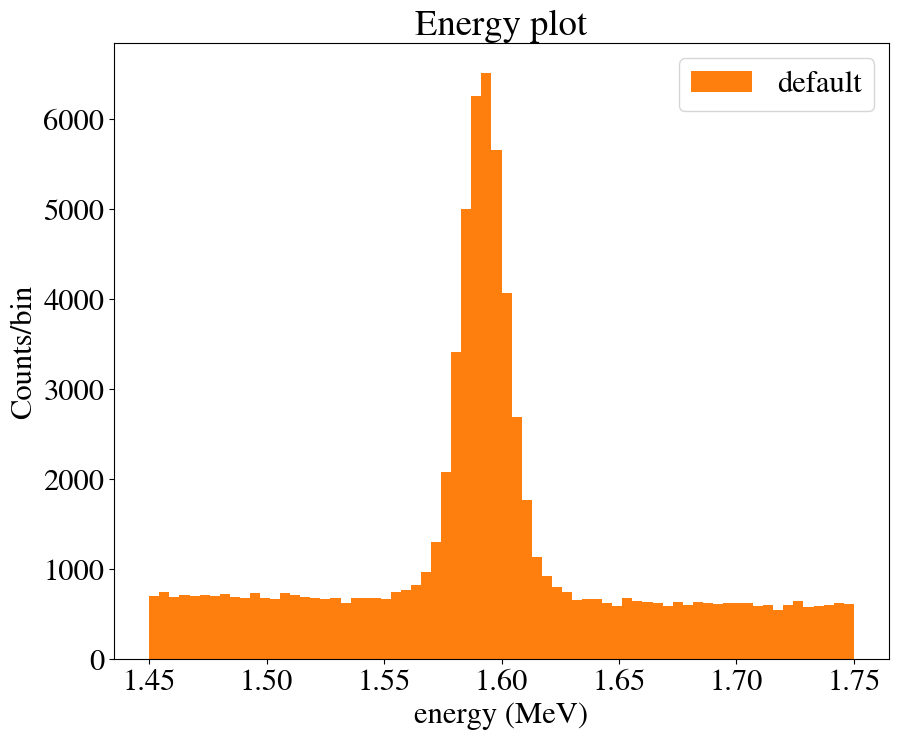

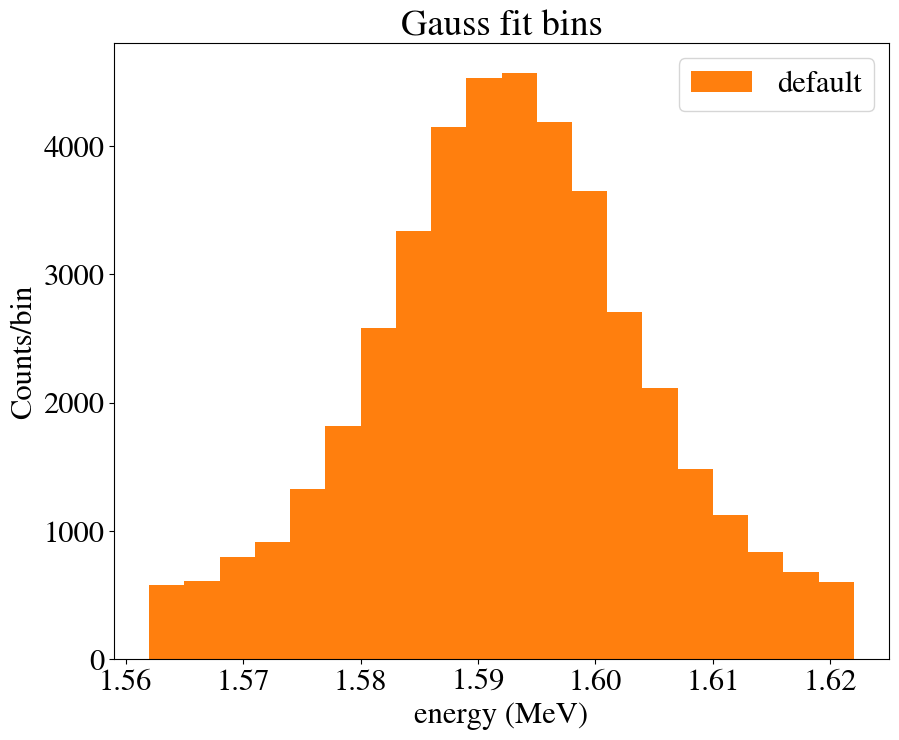

Starting minimization with migrad...
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -5.404e+05                 │         Nfcn = 82 (82 total)         │
│ EDM = 2.75e-06 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
Gaussian fixed at:
mu: 1.5924853393734097
sigma: 0.012647352736536943


Blob cut: 0.0 MeV


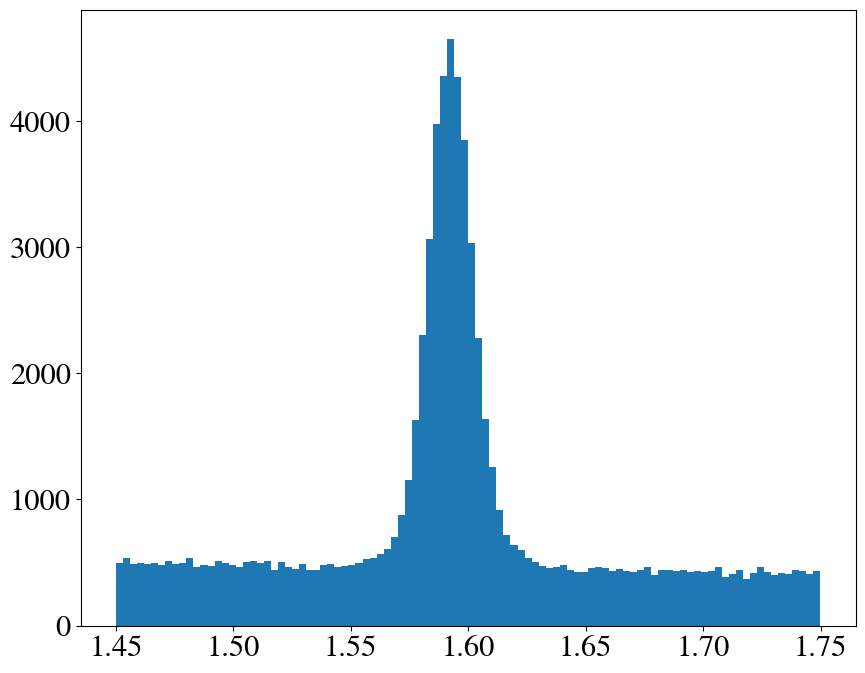

Initial guess:
        Fitting output      
Ns: 39839.0000 ± 0.0000
Nb: 39839.0000 ± 0.0000
tau: 0.9000 ± 0.0000
loc: 1.5925 ± 0.0000
scale: 0.0126 ± 0.0000
Scan and then fit
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -945727.9848284 Edm =      954.047 NCalls =     17
VariableMetric: Iteration #   0 - FCN =  -945727.9848284 Edm =      954.047 NCalls =     17
VariableMetric: Iteration #   1 - FCN =  -946721.2179428 Edm =      415.833 NCalls =     30
VariableMetric: Iteration #   2 - FCN =    -946930.54255 Edm =      16.8437 NCalls =     40
VariableMetric: Iteration #   3 - FCN =  -946947.9640618 Edm =     0.727462 NCalls =     50
VariableMetric: Iteration #   4 - FCN =   -946950.386366 Edm =     0.958625 NCalls =     61
VariableMetric: Iteration #   5 - FCN =  -946951.8787269 Edm =    0.0589731 NCalls =     71
VariableMetric: Iteration #   6 - FCN =  -946951.9768643 Edm =  0.000649783 NCalls =     82
VariableMetric: Iteration #   7 - F

Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: machine accuracy limits further improvement.


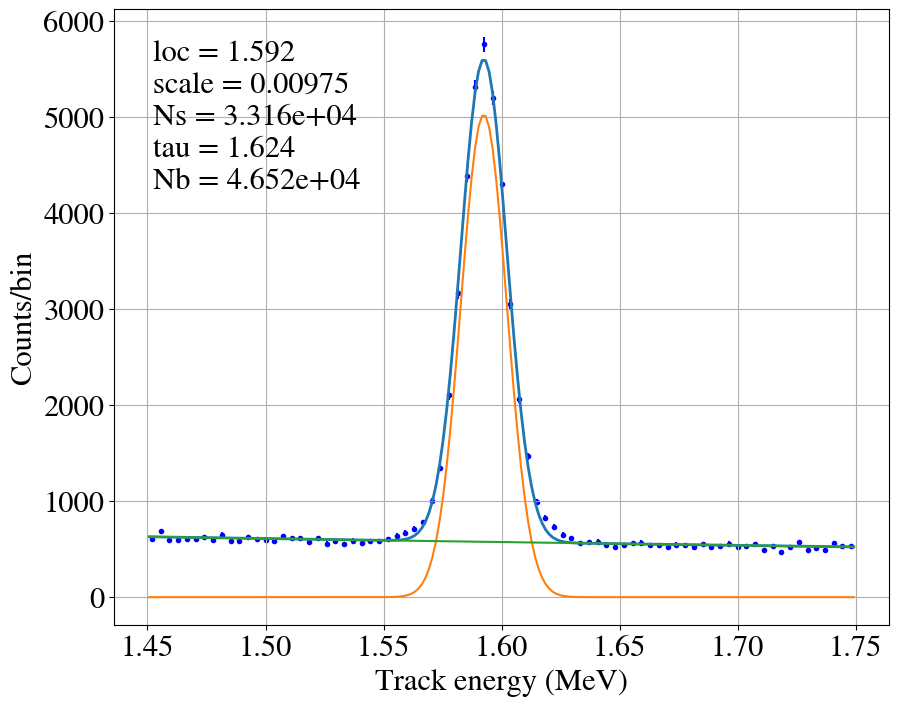

<Figure size 1000x800 with 0 Axes>

Signal events: 33163.76067943101
Background events: 46516.1395777165
Total Events by addition: 79679.90025714751
Total Events by row counting: 79678
FOM: [1.0]
fom_err: [0.008429457208007467]
ns_l: [33163.76067943101]
nb_l: [46516.1395777165]


Blob cut: 0.025 MeV


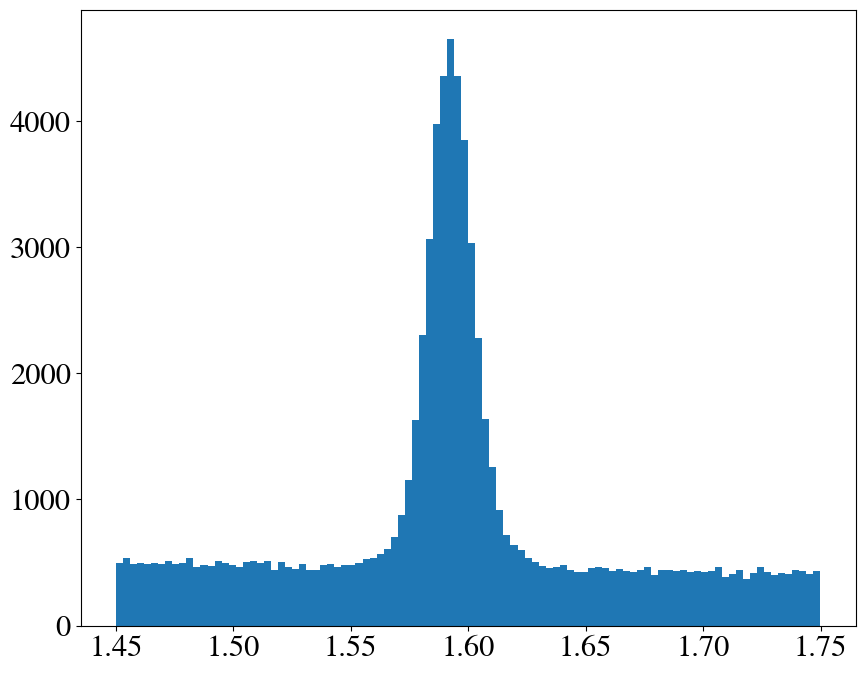

Initial guess:
        Fitting output      
Ns: 39836.5000 ± 0.0000
Nb: 39836.5000 ± 0.0000
tau: 0.9000 ± 0.0000
loc: 1.5925 ± 0.0000
scale: 0.0126 ± 0.0000
Scan and then fit
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -945662.7287007 Edm =      953.594 NCalls =     17
VariableMetric: Iteration #   0 - FCN =  -945662.7287007 Edm =      953.594 NCalls =     17
VariableMetric: Iteration #   1 - FCN =  -946655.8580807 Edm =      414.977 NCalls =     30
VariableMetric: Iteration #   2 - FCN =  -946864.9698555 Edm =      16.8155 NCalls =     40
VariableMetric: Iteration #   3 - FCN =  -946882.3533555 Edm =      0.72366 NCalls =     50
VariableMetric: Iteration #   4 - FCN =  -946884.7628351 Edm =     0.952082 NCalls =     61
VariableMetric: Iteration #   5 - FCN =  -946886.2423968 Edm =    0.0581641 NCalls =     71
VariableMetric: Iteration #   6 - FCN =  -946886.3389047 Edm =  0.000633356 NCalls =     82
VariableMetric: Iteration #   7 - F

Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: machine accuracy limits further improvement.


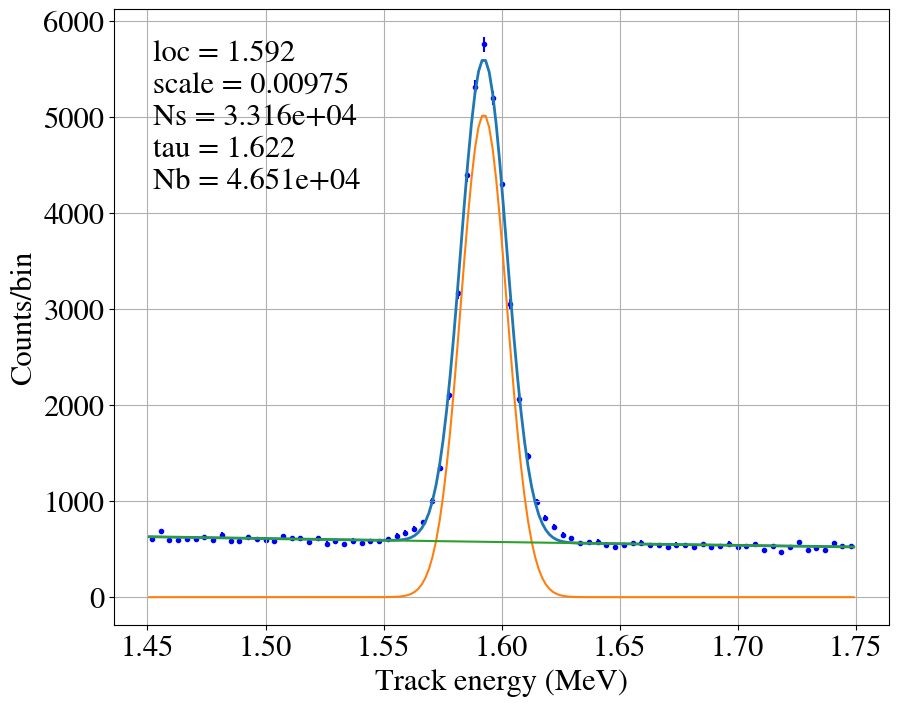

<Figure size 1000x800 with 0 Axes>

Signal events: 33161.20646812808
Background events: 46513.66552130422
Total Events by addition: 79674.8719894323
Total Events by row counting: 79673
FOM: [1.0, 0.9999495743952188]
fom_err: [0.008429457208007467, 0.008429186857958815]
ns_l: [33163.76067943101, 33161.20646812808]
nb_l: [46516.1395777165, 46513.66552130422]


Blob cut: 0.05 MeV


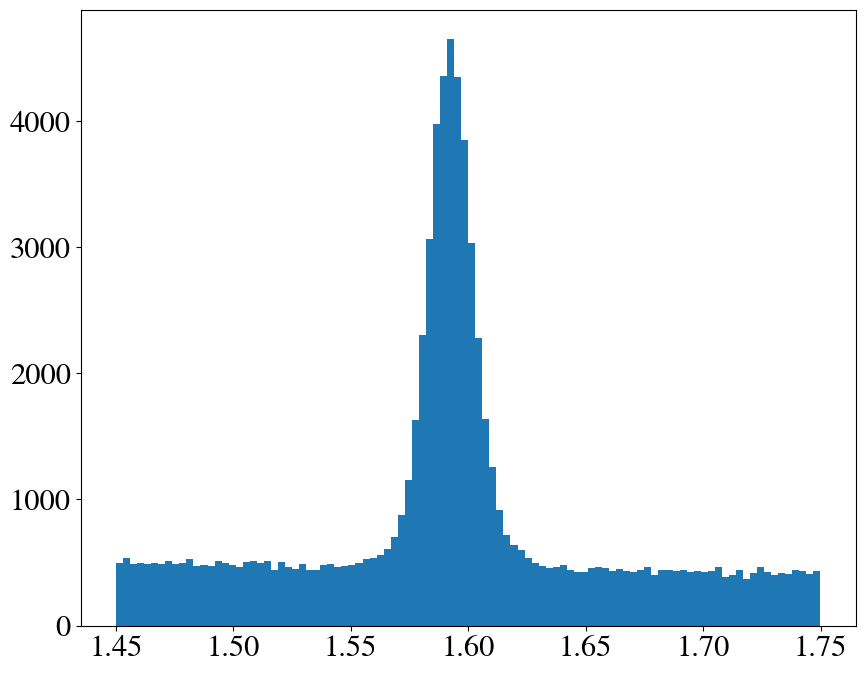

Initial guess:
        Fitting output      
Ns: 39804.0000 ± 0.0000
Nb: 39804.0000 ± 0.0000
tau: 0.9000 ± 0.0000
loc: 1.5925 ± 0.0000
scale: 0.0126 ± 0.0000
Scan and then fit
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -944843.5383853 Edm =      953.548 NCalls =     17
VariableMetric: Iteration #   0 - FCN =  -944843.5383853 Edm =      953.548 NCalls =     17
VariableMetric: Iteration #   1 - FCN =  -945834.4775989 Edm =      417.638 NCalls =     30
VariableMetric: Iteration #   2 - FCN =  -946044.0563402 Edm =      16.8708 NCalls =     40
VariableMetric: Iteration #   3 - FCN =  -946061.5355309 Edm =     0.734147 NCalls =     50
VariableMetric: Iteration #   4 - FCN =  -946063.9731899 Edm =     0.969819 NCalls =     61
VariableMetric: Iteration #   5 - FCN =  -946065.4917536 Edm =    0.0605863 NCalls =     71
VariableMetric: Iteration #   6 - FCN =  -946065.5931895 Edm =  0.000695765 NCalls =     82
VariableMetric: Iteration #   7 - F

Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: machine accuracy limits further improvement.


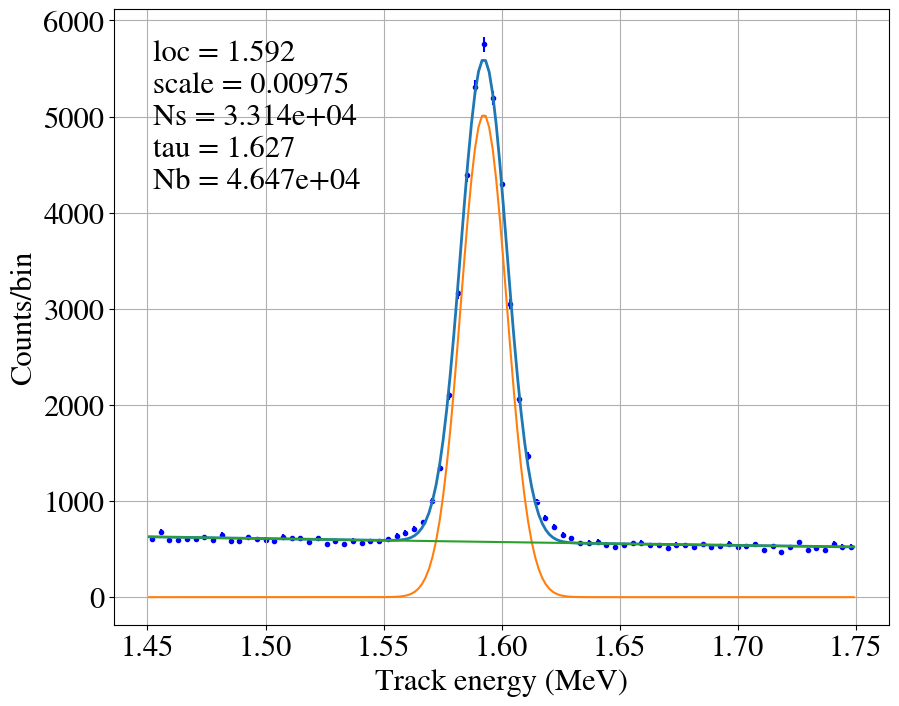

<Figure size 1000x800 with 0 Axes>

Signal events: 33144.45516086648
Background events: 46465.385053317455
Total Events by addition: 79609.84021418393
Total Events by row counting: 79608
FOM: [1.0, 0.9999495743952188, 0.9999635602891126]
fom_err: [0.008429457208007467, 0.008429186857958815, 0.008430539877249473]
ns_l: [33163.76067943101, 33161.20646812808, 33144.45516086648]
nb_l: [46516.1395777165, 46513.66552130422, 46465.385053317455]


Blob cut: 0.07500000000000001 MeV


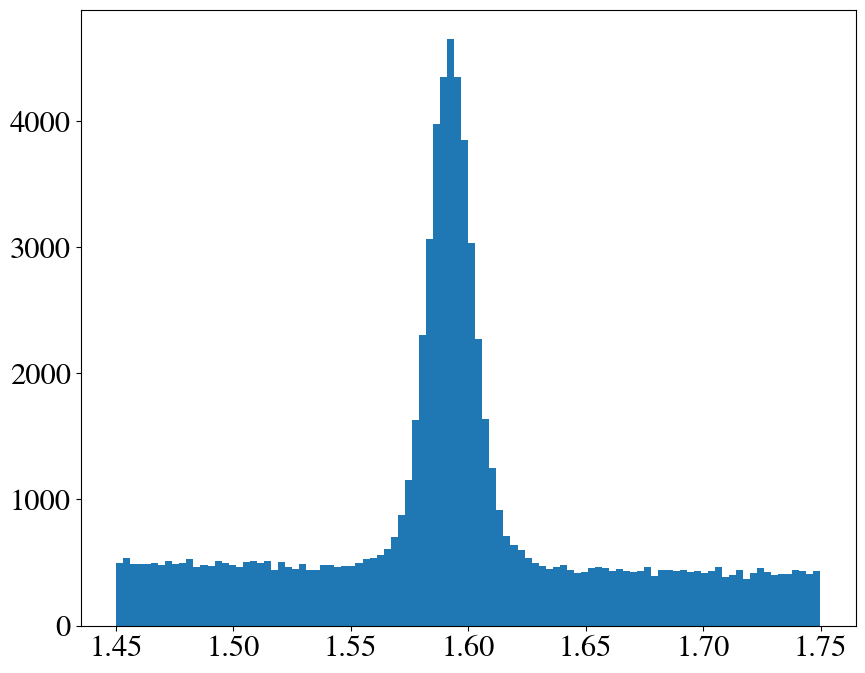

Initial guess:
        Fitting output      
Ns: 39722.0000 ± 0.0000
Nb: 39722.0000 ± 0.0000
tau: 0.9000 ± 0.0000
loc: 1.5925 ± 0.0000
scale: 0.0126 ± 0.0000
Scan and then fit
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -942788.0446339 Edm =      954.632 NCalls =     17
VariableMetric: Iteration #   0 - FCN =  -942788.0446339 Edm =      954.632 NCalls =     17
VariableMetric: Iteration #   1 - FCN =  -943771.6843528 Edm =      432.552 NCalls =     30
VariableMetric: Iteration #   2 - FCN =  -943983.9939187 Edm =       17.178 NCalls =     40
VariableMetric: Iteration #   3 - FCN =  -944001.8486418 Edm =     0.711209 NCalls =     50
VariableMetric: Iteration #   4 - FCN =  -944004.0268587 Edm =     0.925835 NCalls =     61
VariableMetric: Iteration #   5 - FCN =  -944005.5514622 Edm =    0.0613921 NCalls =     72
VariableMetric: Iteration #   6 - FCN =  -944005.6401484 Edm =   0.00187671 NCalls =     83
VariableMetric: Iteration #   7 - F

Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: machine accuracy limits further improvement.


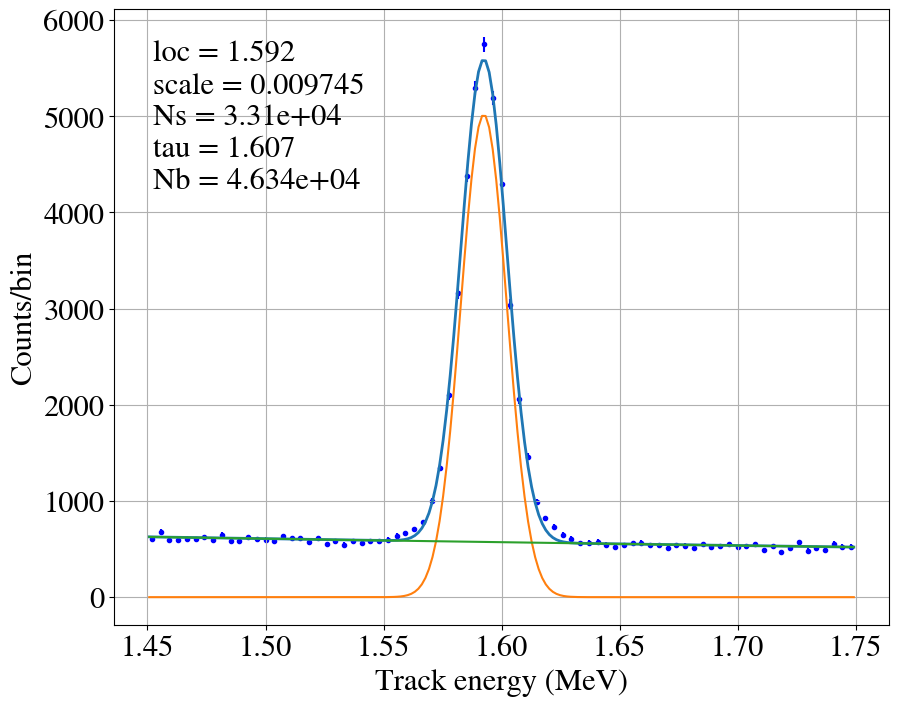

<Figure size 1000x800 with 0 Axes>

Signal events: 33102.50920801971
Background events: 46344.82801210369
Total Events by addition: 79447.33722012339
Total Events by row counting: 79444
FOM: [1.0, 0.9999495743952188, 0.9999635602891126, 0.999996172343165]
fom_err: [0.008429457208007467, 0.008429186857958815, 0.008430539877249473, 0.008433911628949669]
ns_l: [33163.76067943101, 33161.20646812808, 33144.45516086648, 33102.50920801971]
nb_l: [46516.1395777165, 46513.66552130422, 46465.385053317455, 46344.82801210369]


Blob cut: 0.1 MeV


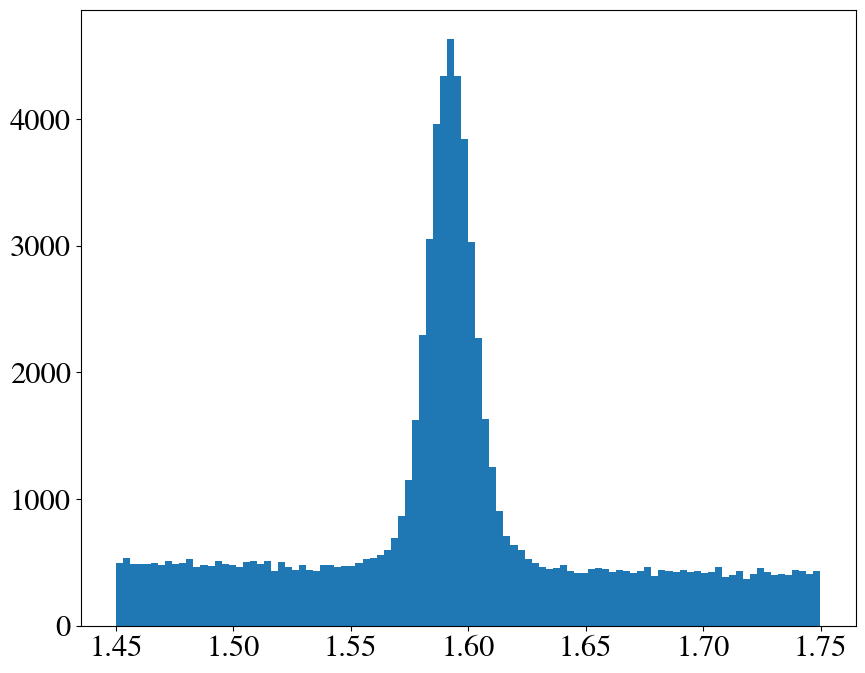

Initial guess:
        Fitting output      
Ns: 39506.5000 ± 0.0000
Nb: 39506.5000 ± 0.0000
tau: 0.9000 ± 0.0000
loc: 1.5925 ± 0.0000
scale: 0.0126 ± 0.0000
Scan and then fit
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -937489.5587596 Edm =      950.629 NCalls =     17
VariableMetric: Iteration #   0 - FCN =  -937489.5587596 Edm =      950.629 NCalls =     17
VariableMetric: Iteration #   1 - FCN =  -938439.0953409 Edm =      478.429 NCalls =     30
VariableMetric: Iteration #   2 - FCN =  -938658.8810221 Edm =      18.0681 NCalls =     40
VariableMetric: Iteration #   3 - FCN =  -938677.9256115 Edm =     0.697467 NCalls =     50
VariableMetric: Iteration #   4 - FCN =   -938679.637331 Edm =     0.808903 NCalls =     61
VariableMetric: Iteration #   5 - FCN =  -938681.2028886 Edm =     0.060284 NCalls =     72
VariableMetric: Iteration #   6 - FCN =  -938681.2866645 Edm =   0.00211632 NCalls =     83
VariableMetric: Iteration #   7 - F

Info: DavidonErrorUpdator: delgam < 0 : first derivatives increasing along search line
Info: VariableMetricBuilder: matrix not pos.def, gdel > 0
Info: gdel = 8.81673e-05
Info in negative or zero diagonal element in covariance matrix : i = 2
Info in added to diagonal of Error matrix a value : dg = 0.506494
Info: gdel = -17084.4


VariableMetric: Iteration #   8 - FCN =  -938681.2878816 Edm =  0.000518994 NCalls =    111


In [ ]:
RUN_NUMBER = '15589, 15590, 15591, 15592, 15593, 15594, 15596'
RUN_NUMBER = [int(x) for x in RUN_NUMBER.split(',')]
TIMESTAMP  = '110725, 120725, 130725, 140725, 150725, 160725, 170725'
TIMESTAMP  = [int(x) for x in TIMESTAMP.split(',')]
CITY       = 'thekla'
FOM_TS     = '20251907'
    

main(RUN_NUMBER, TIMESTAMP, CITY, FOM_TS)